In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_rows', 5000)
import numpy as np
import statistics
import itertools
import math
import numpy
import statistics
import seaborn as sbs

In [9]:
def obereKante(x): #Um Einsteiger zu definieren
    ObereKante = 0.009*x+4.267
    return(ObereKante)

def obereKante_flaeche(x): #Um Einstiegsfläche zu definieren
    ObereKante = 0.009*x+3.55
    return(ObereKante)

def untereKante(x): #Um Einsteiger zu definieren
    UntereKante = 0.015*x+0.434
    return(UntereKante)

def untereKante_flaeche(x): #Um Einsteiger zu definieren
    UntereKante = 0.015*x+1.151
    return(UntereKante)

def leftBorder(x): #Definiert linken Rand der Einstiegsfläche
    leftBorder = x-2.5
    return(leftBorder)

def rightBorder(x): #Definiert rechten Rand der Einstiegsfläche
    rightBorder = x+2.5
    return(rightBorder)

def bottomBorder(x): #Redundant zu Einstiegsflächenfunktion
    bottomBorder = obereKante_flaeche(x)
    return(bottomBorder)

def upperBorder(x): #Redundant zu Einstiegsflächenfunktion
    upperBorder = untereKante_flaeche(x)
    return(upperBorder)

def plotBahnsteig():
    geo = pd.read_csv( "../Daten ZHDB/geo_ZHDB.txt", skiprows = 2, sep = " ", names = ["x", "y", "obj"])
    for obj in geo["obj"].unique():
        plt.plot(geo.loc[geo["obj"] == obj]["x"], geo.loc[geo["obj"] == obj]["y"], color = "black", linewidth = 0.75)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.4, bottom=0.1)
        plt.axis("equal")
        
def getDistance(x1, x2, y1, y2):
    result = math.sqrt((x2 -x1)**2 + (y2 - y1)**2)
    return(result)

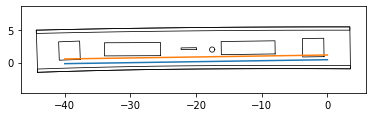

In [16]:
plotBahnsteig()
plt.plot([-40, 0], [untereKante(-40), untereKante(0)])
plt.plot([-40, 0], [upperBorder(-40), upperBorder(0)])

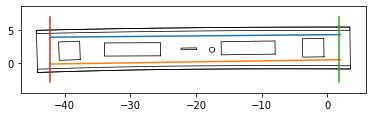

In [14]:
# #Bereich visualisieren, der angibt, wann wir eine Person als Einsteiger definieren
# plotBahnsteig()
# xValues = [-42, 2]
# yValues = [obereKante(-42), obereKante(2)]
# xxx = [untereKante(-42), untereKante(2)]
# plt.plot(xValues, yValues)
# plt.plot(xValues, xxx)
# # plt.plot(xValues, [obereKante_flaeche(-45), obereKante_flaeche(4)])
# # plt.plot(xValues, [untereKante_flaeche(-45), untereKante_flaeche(4)])
# plt.plot([1.75, 1.75], [-3, 7])
# plt.plot([-42.25, -42.25], [-3, 7])

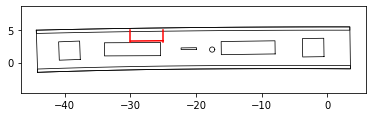

In [15]:
# #Beispiel für eine Einstiegsfläche bei Traubendefinition
# plotBahnsteig()
# xValues = [-30, -25]
# plt.plot([-25, -25], [3.2, 5], color = "red")
# plt.plot([-30, -30], [3.2, 5], color = "red")
# plt.plot(xValues, [obereKante_flaeche(-30), obereKante_flaeche(-25)], color = "red")
# # plt.plot(xValues, [untereKante_flaeche(-45), untereKante_flaeche(4)])
# plt.savefig("Beispiel einer Wartefläche", bbox_inches='tight')

In [5]:
def get_uppers(filename, trauben_size, toleranz_sekunden = 5):
    #Daten einlesen
    data = pd.read_csv("../Daten ZHDB/" + filename, skiprows = 4, sep = "\t", names = ["id", "frame", "x/m", "y/m", "h/m"])

    #Sterbeframe und Oberen auswählen
    sample = data.groupby("id").last()
    sample["YMin"] = list(map(obereKante, sample["x/m"]))
    sample["yes"] = sample["y/m"] > sample["YMin"]
    sample = sample.loc[sample["yes"]]
    sample = sample.loc[(sample["x/m"] <= 1.75) & (sample["x/m"] >= -42.25)]
    uppers = sample

    #HIER WERDEN DIE GRUPPEN FÜR DIE ZEITLICHEN ABSTÄNDE DEFINIERT!
    uppers["id"] = uppers.index
    uppers = uppers.sort_values(["frame", "x/m"])
    uppers["diff"] = uppers.frame.diff()
    uppers = uppers.fillna(0)
    group = 1
    groups = []
    #Es werden gruppen definiert wenn Differenz zur vorherigen person zwischen 0-4 sekunden
    for i in uppers["diff"]:
        if i < 5:
            groups.append(group)
        else:
            group += 1
            groups.append(group)
    uppers["group"] = groups
    df = pd.DataFrame()
    
    #Gruppe bezügliche des x abstands definieren
    uppers["id"] = uppers.index
    for groups in uppers["group"].unique():
        select = uppers.loc[uppers["group"] == groups]
        select = select.sort_values("x/m")
        select["XAbstand"] = select["x/m"].diff()
        select["XAbstand"] = select["XAbstand"].fillna(0)
        xGroup = []
        xgrouper = 1
        for i in select["XAbstand"]:
            if i < 2.5:
                xGroup.append(xgrouper)
            else:
                xgrouper += 1
                xGroup.append(xgrouper)
        select["XGroup"] = xGroup
        df = df.append(select)
    df = df.sort_values(["group", "XGroup", "frame"])
    #999 als Erkennungszeichen für Oberes Gleis
    df["GroupID"] = list(df.group.astype(str) + df.XGroup.astype(str) + "999")
    
    #Definiere eine Series in der alle Ids vorkommen, die in einer Traube vorkommen
    selectTrauben = df["GroupID"].value_counts() == trauben_size
    selectTrauben = pd.DataFrame(selectTrauben)
    selectTrauben["ID"] = selectTrauben.index
    selectTrauben = selectTrauben.loc[selectTrauben["GroupID"] == True, ["ID"]]
    selectTrauben = selectTrauben["ID"]
    
    #Wähle nur Wartetrauben die in ausgewählten Trauben vorkommen und erstelle Spalte für Position der Tür
    df = df.loc[df["GroupID"].isin(selectTrauben)]
    doorLocation = df.groupby("GroupID")["x/m"].mean()
    doorLocation = pd.DataFrame(doorLocation)
    doorLocation["GroupID"] = doorLocation.index
    df.index.name = None
    doorLocation.index.name = None
    df = df.merge(doorLocation, on = "GroupID")
    df["doorPosition"] = df["x/m_y"]
    df["Gleis"] = "oben"
    
    #Door ist minimal über gleiskante, damit alle Personen in fläche sind
    df["doorPositionY"] = df["doorPosition"].apply(obereKante)
    df["doorPositionY"] = df["doorPositionY"]+1.8

    #Fläche zu jeder ID bzw. Wartetraube: leftBorder, rightBorder, bottomBorder
    df["leftBorder"] = df["doorPosition"].apply(leftBorder)
    df["rightBorder"] = df["doorPosition"].apply(rightBorder)
    df["bottomBorder"] = df["doorPosition"].apply(bottomBorder)
    
    #Spalte, die angibt wann Einstiegsvorgang beginnt = Letzter Frame der ersten eingestiegenen Person
    beginnEinstieg = []
    for gruppe in df["GroupID"].unique():
        einstiegDf = df.loc[df["GroupID"] == gruppe]
        einstiegsbeginn = einstiegDf["frame"].min()
        for i in einstiegDf["frame"]:
            beginnEinstieg.append(einstiegsbeginn)
    df["Einstiegsbeginn"] = beginnEinstieg
    
    #Datensatz definieren, in dem alle Frames von den IDs aus 'df' sind. Diesen dann df.Borders zuordnen
    selectID = data.loc[data["id"].isin(df["id"])]
    selectID = selectID.merge(df, on = ["id"])
    selectID = selectID.drop(["frame_y", "yes", "diff", "x/m_x", "YMin", "h/m_y", "y/m_y", "XAbstand", "h/m_x"], axis = 1)
    
    #Columns if x/m in Borders
    selectID["inBorder"] = (selectID["x/m"] > selectID["leftBorder"]) & (selectID["x/m"] < selectID["rightBorder"]) & (selectID["y/m_x"] > selectID["bottomBorder"])

    #Die Zeilen aus selectID löschen, die länger als 5 Sekunden vor dem Einstiegsvorgang sind
    selectID["EinstiegsbeginnToleranz"] = selectID["Einstiegsbeginn"] - toleranz_sekunden
    selectID = selectID.loc[selectID["frame_x"] >= selectID["EinstiegsbeginnToleranz"]]
    
    #Zeile die angibt, wie viele Leute in Fläche
    borderDf = pd.DataFrame(columns = ["GroupID", "frame_x", "numberInArea", "numberAll"])
    for gruppe in selectID["GroupID"].unique():
        selectGroup = selectID.loc[selectID["GroupID"] == gruppe]
        for frame in selectGroup["frame_x"].unique():
            selectFrame = selectGroup[selectGroup["frame_x"] == frame]
            numberInArea = selectFrame.loc[selectFrame["inBorder"] == True, "inBorder"].shape[0]
            numberAll = selectFrame["inBorder"].shape[0]
            df2 = pd.DataFrame([[gruppe, frame, numberInArea, numberAll]], columns = ["GroupID", "frame_x", "numberInArea", "numberAll"])
            borderDf = borderDf.append(df2)
            
    #Endgültiger Df der alle Zeilen von ausgewählten Ids bzw. gruppen enthält
    selectID = selectID.merge(borderDf, on = ["GroupID", "frame_x"])    
    selectID = selectID.drop(["group", "XGroup", "x/m_y"], axis = 1)
    return selectID

In [6]:
def get_downers(filename, trauben_size, toleranz_sekunden = 5):
    #Daten einlesen
    data = pd.read_csv("../Daten ZHDB/" + filename, skiprows = 4, sep = "\t", names = ["id", "frame", "x/m", "y/m", "h/m"])
    #print(filename)
    #Unteren auswählen
    sample = data.groupby("id").last()
    print(filename)
    sample["YMin"] = list(map(untereKante, sample["x/m"]))
    sample["yes"] = sample["y/m"] < sample["YMin"]
    sample = sample.loc[sample["yes"]]
    sample = sample.loc[(sample["x/m"] <= 1.75) & (sample["x/m"] >= -42.25)]
    downers = sample

    #HIER WERDEN DIE GRUPPEN FÜR DIE ZEITLICHEN ABSTÄNDE DEFINIERT!

    downers["id"] = downers.index
    downers = downers.sort_values(["frame", "x/m"])
    downers["diff"] = downers.frame.diff()
    downers = downers.fillna(0)
    group = 1
    groups = []
    #Es werden gruppen definiert wenn Differenz zur vorherigen person zwischen 0-4 sekunden
    for i in downers["diff"]:
        if i < 5:
            groups.append(group)
        else:
            group += 1
            groups.append(group)
    downers["group"] = groups
    df = pd.DataFrame()

    #Gruppe bezügliche des x abstands definieren
    downers["id"] = downers.index
    for groups in downers["group"].unique():
        select = downers.loc[downers["group"] == groups]
        select = select.sort_values("x/m")
        select["XAbstand"] = select["x/m"].diff()
        select["XAbstand"] = select["XAbstand"].fillna(0)
        xGroup = []
        xgrouper = 1
        for i in select["XAbstand"]:
            if i < 2.5:
                xGroup.append(xgrouper)
            else:
                xgrouper += 1
                xGroup.append(xgrouper)
        select["XGroup"] = xGroup
        df = df.append(select)
    df = df.sort_values(["group", "XGroup", "frame"])
    df["GroupID"] = list(df.group.astype(str) + df.XGroup.astype(str) + "111")  #Erkennungszeichen für untere Einsteiger
    
    selectTrauben = df["GroupID"].value_counts() == trauben_size
    selectTrauben = pd.DataFrame(selectTrauben)
    selectTrauben["ID"] = selectTrauben.index
    selectTrauben = selectTrauben.loc[selectTrauben["GroupID"] == True, ["ID"]]
    selectTrauben = selectTrauben["ID"]
    
    df = df.loc[df["GroupID"].isin(selectTrauben)]
    doorLocation = df.groupby("GroupID")["x/m"].mean()
    doorLocation = pd.DataFrame(doorLocation)
    doorLocation["GroupID"] = doorLocation.index
    df.index.name = None
    doorLocation.index.name = None
    df = df.merge(doorLocation, on = "GroupID")
    df["doorPosition"] = df["x/m_y"]
    df["Gleis"] = "unten"

    #Door ist minimal unter gleiskante, damit alle Personen in fläche sind
    df["doorPositionY"] = df["doorPosition"].apply(untereKante)
    df["doorPositionY"] = df["doorPositionY"]-1.9
    
    #Fläche zu jeder ID bzw. Wartetraube: leftBorder, rightBorder, upperBorder
    df["leftBorder"] = df["doorPosition"].apply(leftBorder)
    df["rightBorder"] = df["doorPosition"].apply(rightBorder)
    df["upperBorder"] = df["doorPosition"].apply(upperBorder)
    
    #Spalte, die angibt wann Einstiegsvorgang beginnt = Letzter Frame der ersten eingestiegenen Person
    beginnEinstieg = []
    for gruppe in df["GroupID"].unique():
        einstiegDf = df.loc[df["GroupID"] == gruppe]
        einstiegsbeginn = einstiegDf["frame"].min()
        for i in einstiegDf["frame"]:
            beginnEinstieg.append(einstiegsbeginn)
    df["Einstiegsbeginn"] = beginnEinstieg
    
    #Datensatz definieren, in dem alle Frames von den IDs aus 'df' sind. Diesen dann df.Borders zuordnen
    selectID = data.loc[data["id"].isin(df["id"])]
    selectID = selectID.merge(df, on = ["id"])
    selectID = selectID.drop(["frame_y", "yes", "diff", "x/m_x", "YMin", "h/m_y", "y/m_y", "XAbstand", "h/m_x"], axis = 1)
    
    #Columns if x/m in Borders
    selectID["inBorder"] = (selectID["x/m"] > selectID["leftBorder"]) & (selectID["x/m"] < selectID["rightBorder"]) & (selectID["y/m_x"] < selectID["upperBorder"])
    #Die Zeilen aus selectID löschen, die länger als 5 Sekunden vor dem Einstiegsvorgang sind
    selectID["EinstiegsbeginnToleranz"] = selectID["Einstiegsbeginn"] - toleranz_sekunden
    selectID = selectID.loc[selectID["frame_x"] >= selectID["EinstiegsbeginnToleranz"]]
    
    #Zeile die angibt, wie viele Leute in Fläche
    borderDf = pd.DataFrame(columns = ["GroupID", "frame_x", "numberInArea", "numberAll"])
    for gruppe in selectID["GroupID"].unique():
        selectGroup = selectID.loc[selectID["GroupID"] == gruppe]
        for frame in selectGroup["frame_x"].unique():
            selectFrame = selectGroup[selectGroup["frame_x"] == frame]
            numberInArea = selectFrame.loc[selectFrame["inBorder"] == True, "inBorder"].shape[0]
            numberAll = selectFrame["inBorder"].shape[0]
            df2 = pd.DataFrame([[gruppe, frame, numberInArea, numberAll]], columns = ["GroupID", "frame_x", "numberInArea", "numberAll"])
            borderDf = borderDf.append(df2)

    selectID = selectID.merge(borderDf, on = ["GroupID", "frame_x"])
    selectID = selectID.drop(["group", "XGroup", "x/m_y"], axis = 1)
    return(selectID)

In [7]:
def get_whole_df(filename, trauben_size, toleranz_sekunden = 5):
    uppers = get_uppers(filename, trauben_size, toleranz_sekunden)
    downers = get_downers(filename, trauben_size, toleranz_sekunden)
    df = downers.append(uppers)
    return(df)

In [8]:
# df = get_whole_df("ZHDB_0205_6_20.txt", 5)

In [9]:
# df.groupby("Gleis")["inBorder"].value_counts()

In [10]:
#Doppelte Frames werden auch doppel gezählt, so soll es sein!
def get_average_person_number(filename, frame_list):
    personen_auf_bahnsteig = []
    data = pd.read_csv("../Daten ZHDB/" + filename, skiprows = 4, sep = "\t", names = ["id", "frame", "x/m", "y/m", "h/m"])
    for frame in frame_list:
        df = data.loc[data["frame"] == frame]
        personen_auf_bahnsteig.append(len(df["frame"]))
#     print(ave)
    return(statistics.mean(personen_auf_bahnsteig))

In [11]:
def get_all_distances(selectID, inBorder = True):
    borderDistance = []
    if inBorder:
        selectIDBorder = selectID.loc[selectID["inBorder"] == True]
    else:
        selectIDBorder = selectID
        
    for gruppe in selectIDBorder["GroupID"].unique():
        selectGroup = selectIDBorder.loc[selectIDBorder["GroupID"] == gruppe, ["id", "frame_x", "x/m", "y/m_x"]]
        for frame in selectGroup["frame_x"].unique():
            selectFrame = selectGroup.loc[selectGroup["frame_x"] == frame]
            for contact in itertools.combinations(selectFrame["id"], 2):
                firstPosition = selectFrame.loc[selectFrame["id"] == contact[0], ["x/m", "y/m_x"]]
                secondPosition = selectFrame.loc[selectFrame["id"] == contact[1], ["x/m", "y/m_x"]]
                distanz = getDistance(x1 = float(firstPosition["x/m"]), x2 = float(secondPosition["x/m"]), y1 = float(firstPosition["y/m_x"]), y2 = float(secondPosition["y/m_x"]))
                borderDistance.append(distanz)
    return borderDistance